In [1]:
"""
    Dataset (Bangla ( Bengali ) sentiment analysis classification benchmark dataset corpus) : https://data.mendeley.com/datasets/p6zc7krs37/4
"""
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import pandas as pd
import string
import numpy as np
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import *
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing
from tensorflow.keras import mixed_precision
import tensorflow as tf
tf.keras.mixed_precision.experimental.Policy('mixed_float16')
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
# Loading Bangla ( Bengali ) sentiment analysis classification benchmark dataset
positive_sentences = []
f = open('../datasets/all_positive_8500.txt','r', encoding = 'utf-8')
for line in f:
    positive_sentences.append(line.strip())

negative_sentences = []
f = open('../datasets/all_negative_3307.txt','r', encoding = 'utf-8')
for line in f:
    negative_sentences.append(line.strip())
    
print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')

import random
random.shuffle(positive_sentences)

for i in range(len(positive_sentences)-len(negative_sentences)):
    positive_sentences.pop(0)

print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')


y_pos = [1 for i in range(len(positive_sentences))]
y_neg = [0 for i in range(len(negative_sentences))]

X = positive_sentences + negative_sentences
y = y_pos + y_neg

8500 positive sentences
3307 negative sentences
3307 positive sentences
3307 negative sentences


In [3]:
w2v_model = Word2Vec.load("word2vec.model")
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print(vocab_size)

221473


In [4]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
y = np.array(y)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train_val = X_train
y_train_val = y_train

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val)



In [5]:
from tensorflow.keras.layers import Embedding
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [6]:
def nlp_lstm(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding_layer = embedding_layer(inputs)

    lstm1 = Bidirectional(LSTM(100,return_sequences=True, return_state=True))(embedding_layer)
    lstm2 = Bidirectional(LSTM(100,return_sequences=True, return_state=True))(lstm1)
    output = Dense(units=1, activation='sigmoid')(lstm2[1])
    
    model = Model(inputs, output)
    return model


model = nlp_lstm(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm.hdf5', save_freq="epoch",  verbose=1, monitor='val_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.00005)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 228)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 228, 100)     22147300    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 228, 200), ( 160800      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 228, 200), ( 240800      bidirectional[0][0]              
                                                                 bidirectional[0][1]   

Epoch 18/100
133/133 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.9577
Epoch 00018: val_accuracy improved from 0.88857 to 0.89235, saving model to ./weight_cp\weight_lstm.hdf5
133/133 [==============================] - 5s 38ms/step - loss: 0.1177 - accuracy: 0.9577 - val_loss: 0.2741 - val_accuracy: 0.8924
Epoch 19/100
131/133 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9614
Epoch 00019: val_accuracy improved from 0.89235 to 0.89613, saving model to ./weight_cp\weight_lstm.hdf5
133/133 [==============================] - 5s 39ms/step - loss: 0.1121 - accuracy: 0.9615 - val_loss: 0.2782 - val_accuracy: 0.8961
Epoch 20/100
133/133 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.9662
Epoch 00020: val_accuracy did not improve from 0.89613
133/133 [==============================] - 5s 35ms/step - loss: 0.0992 - accuracy: 0.9662 - val_loss: 0.2916 - val_accuracy: 0.8933
Epoch 21/100
133/133 [=======================

133/133 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9962
Epoch 00046: val_accuracy did not improve from 0.89802
133/133 [==============================] - 4s 34ms/step - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.5112 - val_accuracy: 0.8876
Epoch 47/100
133/133 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9960
Epoch 00047: val_accuracy did not improve from 0.89802
133/133 [==============================] - 5s 34ms/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.5361 - val_accuracy: 0.8839
Epoch 48/100
132/133 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9929
Epoch 00048: val_accuracy did not improve from 0.89802
133/133 [==============================] - 4s 34ms/step - loss: 0.0190 - accuracy: 0.9929 - val_loss: 0.5473 - val_accuracy: 0.8867
Epoch 49/100
132/133 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9974
Epoch 00049: val_accuracy did not improve from 0.89802
133/1

Epoch 75/100
131/133 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9990
Epoch 00075: val_accuracy did not improve from 0.89802
133/133 [==============================] - 5s 34ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 0.6804 - val_accuracy: 0.8801
Epoch 76/100
131/133 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9983
Epoch 00076: val_accuracy did not improve from 0.89802
133/133 [==============================] - 4s 33ms/step - loss: 0.0050 - accuracy: 0.9983 - val_loss: 0.7144 - val_accuracy: 0.8791
Epoch 77/100
133/133 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9995
Epoch 00077: val_accuracy did not improve from 0.89802
133/133 [==============================] - 4s 34ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.7569 - val_accuracy: 0.8725
Epoch 78/100
131/133 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9969
Epoch 00078: val_accuracy did not improve from 

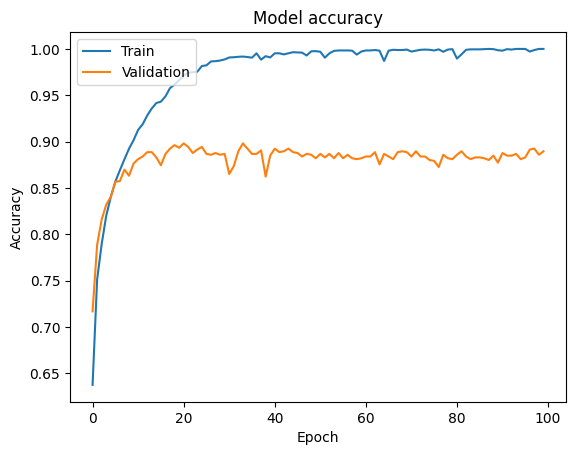

In [7]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
model = load_model('./weight_cp/weight_lstm.hdf5')
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF LSTM
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       661
           1       0.91      0.87      0.89       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.89      1323
weighted avg       0.89      0.89      0.89      1323

0.8888888888888888


In [9]:
def nlp_ds(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding_layer = embedding_layer(inputs)

    lstm1 = Bidirectional(LSTM(100,return_sequences=True, return_state=True))(embedding_layer)
    lstm2 = Bidirectional(LSTM(100,return_sequences=True, return_state=True))(lstm1)
    
    output1 = Dense(units=1, activation='sigmoid', name='lstm_1')(lstm1[1])
    output2 = Dense(units=1, activation='sigmoid', name='lstm_2')(lstm2[1])
    model = Model(inputs, [output1, output2])
    return model


model = nlp_ds(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm.hdf5', save_freq="epoch",  verbose=1, monitor='val_lstm_2_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.00005)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 228)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 228, 100)     22147300    input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 228, 200), ( 160800      embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 228, 200), ( 240800      bidirectional_2[0][0]            
                                                                 bidirectional_2[0][1] 

Epoch 10/100
133/133 [==============================] - ETA: 0s - loss: 0.6138 - lstm_1_loss: 0.3726 - lstm_2_loss: 0.2412 - lstm_1_accuracy: 0.8469 - lstm_2_accuracy: 0.9003
Epoch 00010: val_lstm_2_accuracy improved from 0.86686 to 0.86969, saving model to ./weight_cp\weight_lstm.hdf5
133/133 [==============================] - 5s 39ms/step - loss: 0.6138 - lstm_1_loss: 0.3726 - lstm_2_loss: 0.2412 - lstm_1_accuracy: 0.8469 - lstm_2_accuracy: 0.9003 - val_loss: 0.6815 - val_lstm_1_loss: 0.3823 - val_lstm_2_loss: 0.2992 - val_lstm_1_accuracy: 0.8310 - val_lstm_2_accuracy: 0.8697
Epoch 11/100
133/133 [==============================] - ETA: 0s - loss: 0.5747 - lstm_1_loss: 0.3523 - lstm_2_loss: 0.2223 - lstm_1_accuracy: 0.8537 - lstm_2_accuracy: 0.9095
Epoch 00011: val_lstm_2_accuracy improved from 0.86969 to 0.88102, saving model to ./weight_cp\weight_lstm.hdf5
133/133 [==============================] - 5s 38ms/step - loss: 0.5747 - lstm_1_loss: 0.3523 - lstm_2_loss: 0.2223 - lstm_1_accu

Epoch 25/100
133/133 [==============================] - ETA: 0s - loss: 0.2747 - lstm_1_loss: 0.2185 - lstm_2_loss: 0.0562 - lstm_1_accuracy: 0.9178 - lstm_2_accuracy: 0.9853
Epoch 00025: val_lstm_2_accuracy improved from 0.89518 to 0.90179, saving model to ./weight_cp\weight_lstm.hdf5
133/133 [==============================] - 5s 38ms/step - loss: 0.2747 - lstm_1_loss: 0.2185 - lstm_2_loss: 0.0562 - lstm_1_accuracy: 0.9178 - lstm_2_accuracy: 0.9853 - val_loss: 0.6300 - val_lstm_1_loss: 0.2925 - val_lstm_2_loss: 0.3375 - val_lstm_1_accuracy: 0.8763 - val_lstm_2_accuracy: 0.9018
Epoch 26/100
132/133 [============================>.] - ETA: 0s - loss: 0.2683 - lstm_1_loss: 0.2140 - lstm_2_loss: 0.0542 - lstm_1_accuracy: 0.9216 - lstm_2_accuracy: 0.9813
Epoch 00026: val_lstm_2_accuracy did not improve from 0.90179
133/133 [==============================] - 5s 35ms/step - loss: 0.2689 - lstm_1_loss: 0.2143 - lstm_2_loss: 0.0547 - lstm_1_accuracy: 0.9213 - lstm_2_accuracy: 0.9811 - val_loss:

132/133 [============================>.] - ETA: 0s - loss: 0.1590 - lstm_1_loss: 0.1435 - lstm_2_loss: 0.0155 - lstm_1_accuracy: 0.9536 - lstm_2_accuracy: 0.9955
Epoch 00040: val_lstm_2_accuracy did not improve from 0.90179
133/133 [==============================] - 5s 35ms/step - loss: 0.1588 - lstm_1_loss: 0.1433 - lstm_2_loss: 0.0155 - lstm_1_accuracy: 0.9537 - lstm_2_accuracy: 0.9955 - val_loss: 0.6632 - val_lstm_1_loss: 0.2780 - val_lstm_2_loss: 0.3853 - val_lstm_1_accuracy: 0.8886 - val_lstm_2_accuracy: 0.8942
Epoch 41/100
132/133 [============================>.] - ETA: 0s - loss: 0.1593 - lstm_1_loss: 0.1425 - lstm_2_loss: 0.0168 - lstm_1_accuracy: 0.9536 - lstm_2_accuracy: 0.9957
Epoch 00041: val_lstm_2_accuracy did not improve from 0.90179
133/133 [==============================] - 5s 34ms/step - loss: 0.1592 - lstm_1_loss: 0.1424 - lstm_2_loss: 0.0168 - lstm_1_accuracy: 0.9537 - lstm_2_accuracy: 0.9957 - val_loss: 0.7153 - val_lstm_1_loss: 0.2753 - val_lstm_2_loss: 0.4400 - v

Epoch 56/100
133/133 [==============================] - ETA: 0s - loss: 0.0935 - lstm_1_loss: 0.0879 - lstm_2_loss: 0.0056 - lstm_1_accuracy: 0.9745 - lstm_2_accuracy: 0.9981
Epoch 00056: val_lstm_2_accuracy did not improve from 0.90179
133/133 [==============================] - 5s 35ms/step - loss: 0.0935 - lstm_1_loss: 0.0879 - lstm_2_loss: 0.0056 - lstm_1_accuracy: 0.9745 - lstm_2_accuracy: 0.9981 - val_loss: 0.8479 - val_lstm_1_loss: 0.2919 - val_lstm_2_loss: 0.5559 - val_lstm_1_accuracy: 0.8905 - val_lstm_2_accuracy: 0.8924
Epoch 57/100
133/133 [==============================] - ETA: 0s - loss: 0.0904 - lstm_1_loss: 0.0863 - lstm_2_loss: 0.0041 - lstm_1_accuracy: 0.9757 - lstm_2_accuracy: 0.9995
Epoch 00057: val_lstm_2_accuracy did not improve from 0.90179
133/133 [==============================] - 5s 34ms/step - loss: 0.0904 - lstm_1_loss: 0.0863 - lstm_2_loss: 0.0041 - lstm_1_accuracy: 0.9757 - lstm_2_accuracy: 0.9995 - val_loss: 0.8809 - val_lstm_1_loss: 0.3211 - val_lstm_2_los

133/133 [==============================] - ETA: 0s - loss: 0.0665 - lstm_1_loss: 0.0621 - lstm_2_loss: 0.0045 - lstm_1_accuracy: 0.9865 - lstm_2_accuracy: 0.9983
Epoch 00071: val_lstm_2_accuracy did not improve from 0.90179
133/133 [==============================] - 5s 34ms/step - loss: 0.0665 - lstm_1_loss: 0.0621 - lstm_2_loss: 0.0045 - lstm_1_accuracy: 0.9865 - lstm_2_accuracy: 0.9983 - val_loss: 0.8687 - val_lstm_1_loss: 0.3456 - val_lstm_2_loss: 0.5231 - val_lstm_1_accuracy: 0.8905 - val_lstm_2_accuracy: 0.8876
Epoch 72/100
131/133 [============================>.] - ETA: 0s - loss: 0.0606 - lstm_1_loss: 0.0571 - lstm_2_loss: 0.0035 - lstm_1_accuracy: 0.9893 - lstm_2_accuracy: 0.9990
Epoch 00072: val_lstm_2_accuracy did not improve from 0.90179
133/133 [==============================] - 5s 35ms/step - loss: 0.0604 - lstm_1_loss: 0.0570 - lstm_2_loss: 0.0034 - lstm_1_accuracy: 0.9894 - lstm_2_accuracy: 0.9991 - val_loss: 0.9241 - val_lstm_1_loss: 0.3615 - val_lstm_2_loss: 0.5626 - v

Epoch 87/100
133/133 [==============================] - ETA: 0s - loss: 0.0438 - lstm_1_loss: 0.0406 - lstm_2_loss: 0.0033 - lstm_1_accuracy: 0.9929 - lstm_2_accuracy: 0.9993
Epoch 00087: val_lstm_2_accuracy did not improve from 0.90179
133/133 [==============================] - 5s 35ms/step - loss: 0.0438 - lstm_1_loss: 0.0406 - lstm_2_loss: 0.0033 - lstm_1_accuracy: 0.9929 - lstm_2_accuracy: 0.9993 - val_loss: 0.9048 - val_lstm_1_loss: 0.3711 - val_lstm_2_loss: 0.5337 - val_lstm_1_accuracy: 0.9018 - val_lstm_2_accuracy: 0.8886
Epoch 88/100
132/133 [============================>.] - ETA: 0s - loss: 0.0412 - lstm_1_loss: 0.0391 - lstm_2_loss: 0.0021 - lstm_1_accuracy: 0.9936 - lstm_2_accuracy: 0.9995
Epoch 00088: val_lstm_2_accuracy did not improve from 0.90179
133/133 [==============================] - 5s 35ms/step - loss: 0.0412 - lstm_1_loss: 0.0391 - lstm_2_loss: 0.0021 - lstm_1_accuracy: 0.9936 - lstm_2_accuracy: 0.9995 - val_loss: 0.9093 - val_lstm_1_loss: 0.3642 - val_lstm_2_los

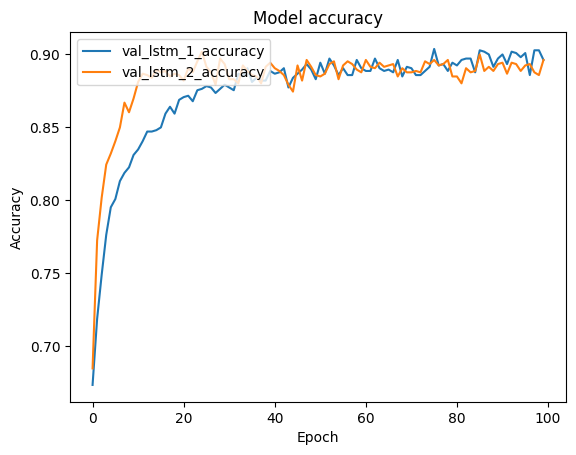

In [10]:
from matplotlib import pyplot as plt
plt.plot(history.history['val_lstm_1_accuracy'])
plt.plot(history.history['val_lstm_2_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_lstm_1_accuracy', 'val_lstm_2_accuracy'], loc='upper left')
plt.show()

In [11]:
model = load_model('./weight_cp/weight_lstm.hdf5')
predictions1 = model.predict(X_test)[0]
predictions2 = model.predict(X_test)[1]
print(predictions1.shape)
predictions = np.mean((predictions1, predictions2), axis=0)
print(predictions.shape)
predictions = np.where(predictions > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF LSTM DS (Averaged)")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

(1323, 1)
(1323, 1)
CLASSIFICATION REPORT OF LSTM DS (Averaged)
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       661
           1       0.90      0.90      0.90       662

    accuracy                           0.90      1323
   macro avg       0.90      0.90      0.90      1323
weighted avg       0.90      0.90      0.90      1323

0.9009826152683296


In [12]:
predictions = np.where(predictions2 > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF LSTM DS (Last Layer)")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF LSTM DS (Last Layer)
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       661
           1       0.90      0.88      0.89       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.89      1323
weighted avg       0.89      0.89      0.89      1323

0.889644746787604


In [13]:
predictions = np.where(predictions1 > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF LSTM DS (First Layer)")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF LSTM DS (First Layer)
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       661
           1       0.88      0.89      0.89       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.89      1323
weighted avg       0.89      0.89      0.89      1323

0.8858654572940288
